<h3> Loading train_data for training models


In [1]:
# loading data from txt file in JSON format

import json

train_file = open('train.txt')
train_data = json.load(train_file)

In [2]:
# creating alias for more direct call

train_t = train_data['t']
train_xs = train_data['c_{XS}']
train_x = train_data['c_{X}']
train_x_2 = train_data['c_{X_2}']

n_exp = len(train_xs)
print(n_exp)
n_t = len(train_xs[0])
print(n_t)
print(train_t)


50
101
[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3, 1.4000000000000001, 1.5, 1.6, 1.7000000000000002, 1.8, 1.9000000000000001, 2.0, 2.1, 2.2, 2.3000000000000003, 2.4000000000000004, 2.5, 2.6, 2.7, 2.8000000000000003, 2.9000000000000004, 3.0, 3.1, 3.2, 3.3000000000000003, 3.4000000000000004, 3.5, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.0, 4.1000000000000005, 4.2, 4.3, 4.4, 4.5, 4.6000000000000005, 4.7, 4.800000000000001, 4.9, 5.0, 5.1000000000000005, 5.2, 5.300000000000001, 5.4, 5.5, 5.6000000000000005, 5.7, 5.800000000000001, 5.9, 6.0, 6.1000000000000005, 6.2, 6.300000000000001, 6.4, 6.5, 6.6000000000000005, 6.7, 6.800000000000001, 6.9, 7.0, 7.1000000000000005, 7.2, 7.300000000000001, 7.4, 7.5, 7.6000000000000005, 7.7, 7.800000000000001, 7.9, 8.0, 8.1, 8.200000000000001, 8.3, 8.4, 8.5, 8.6, 8.700000000000001, 8.8, 8.9, 9.0, 9.1, 9.200000000000001, 9.3, 9.4, 9.5, 9.600000000000001, 9.70000

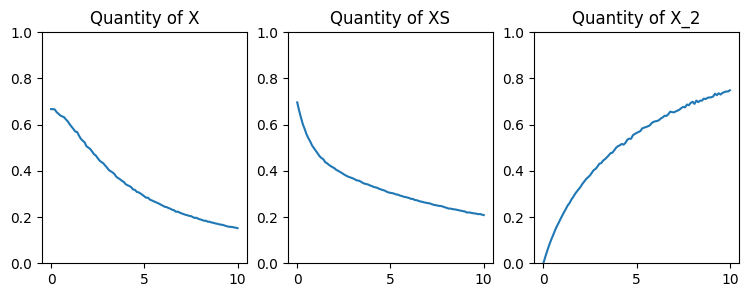

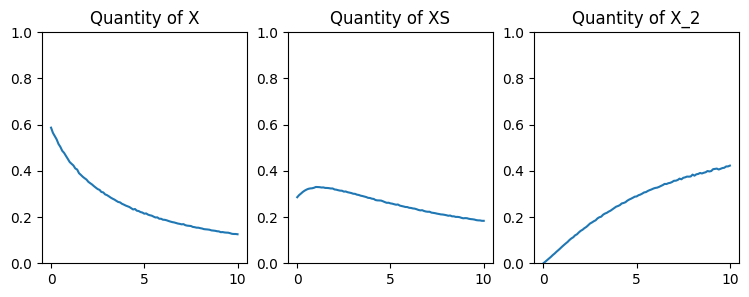

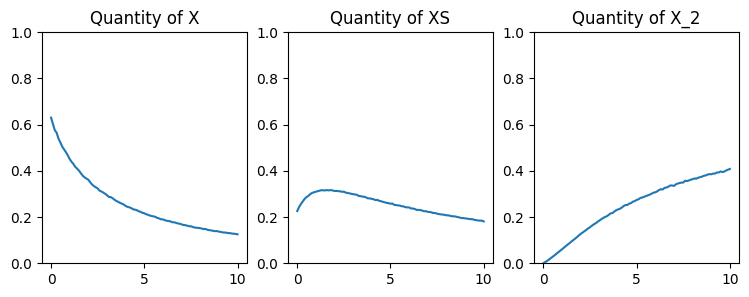

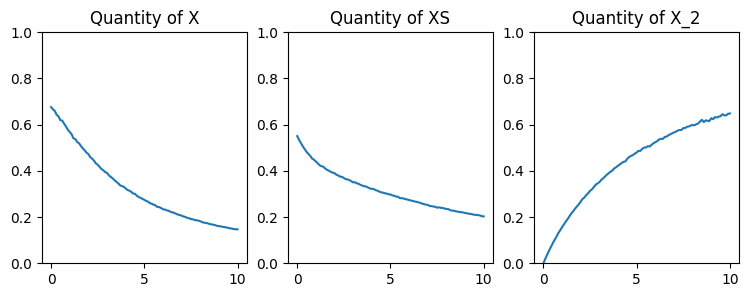

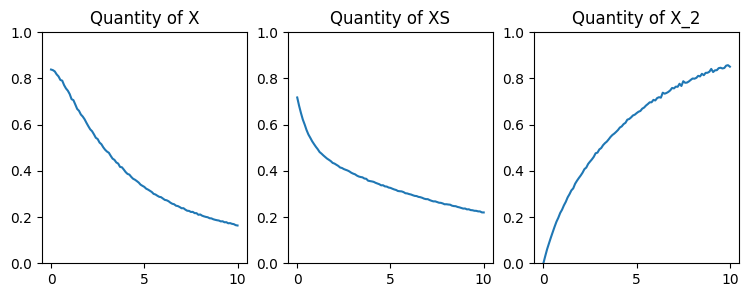

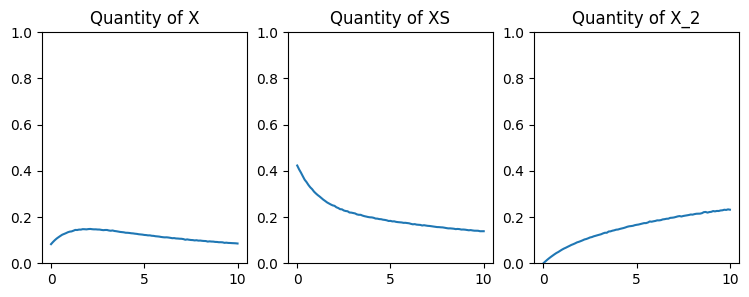

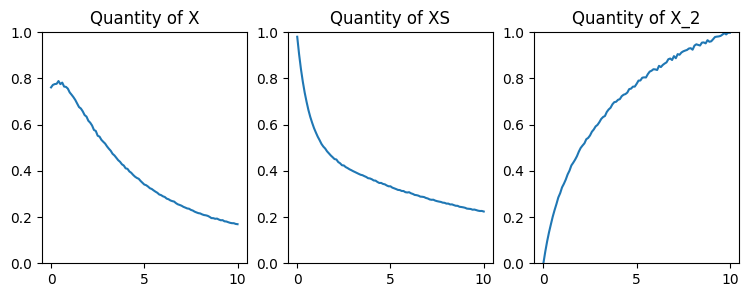

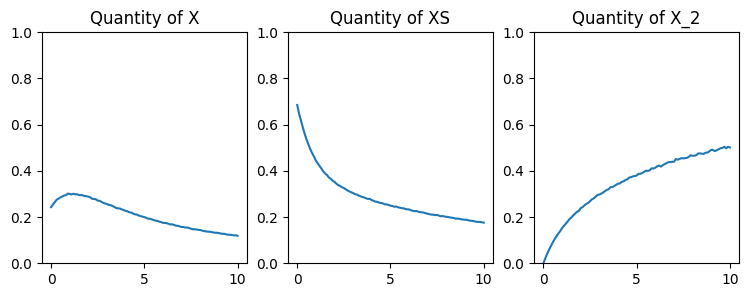

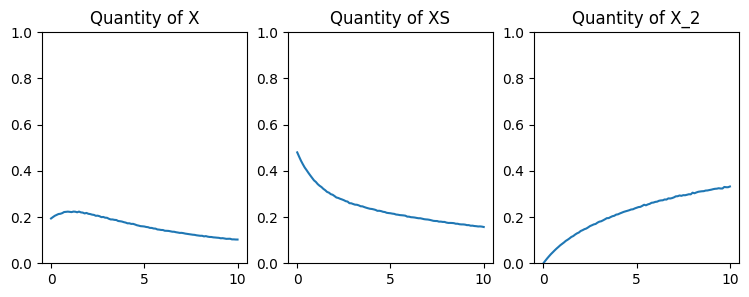

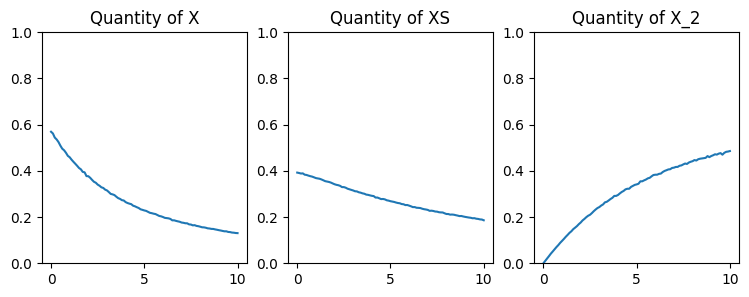

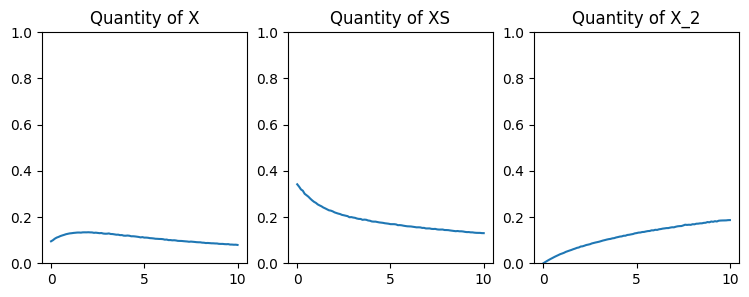

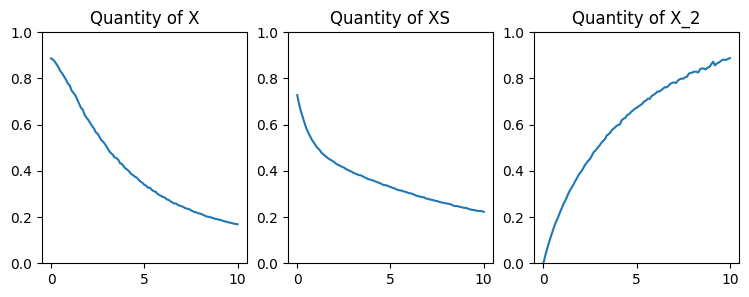

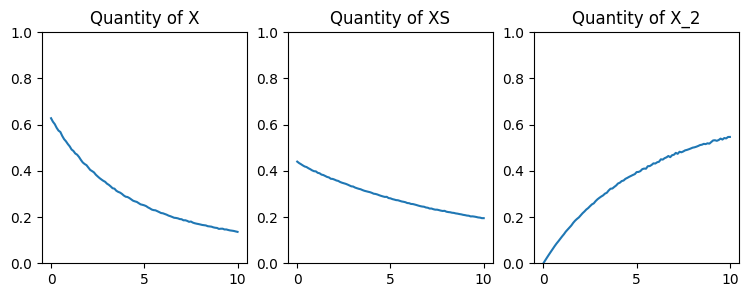

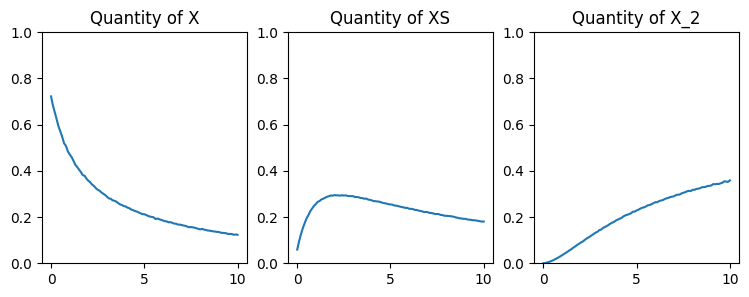

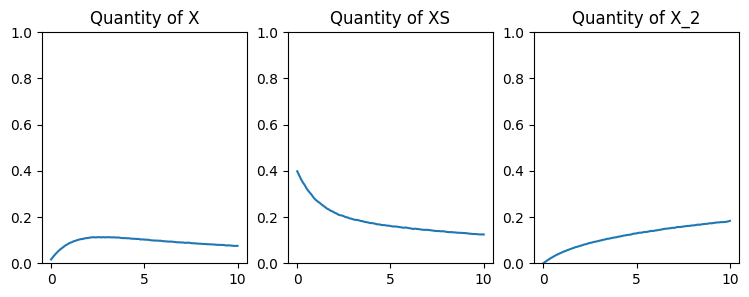

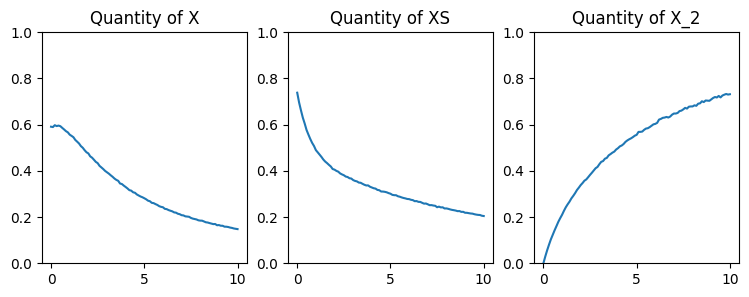

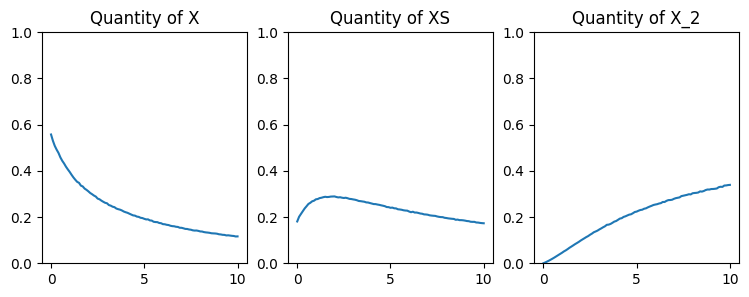

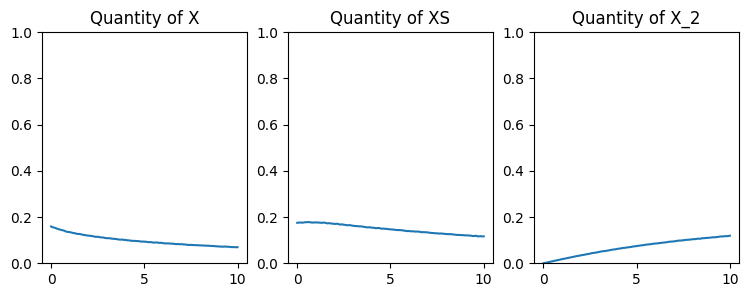

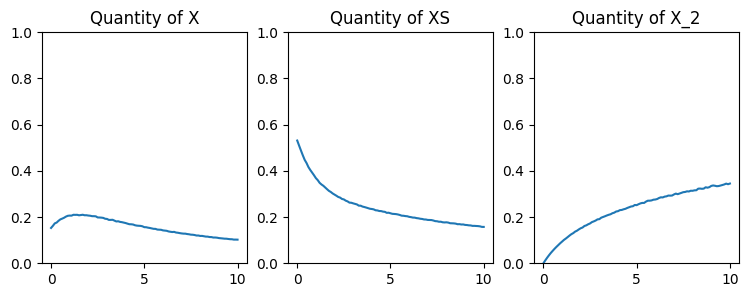

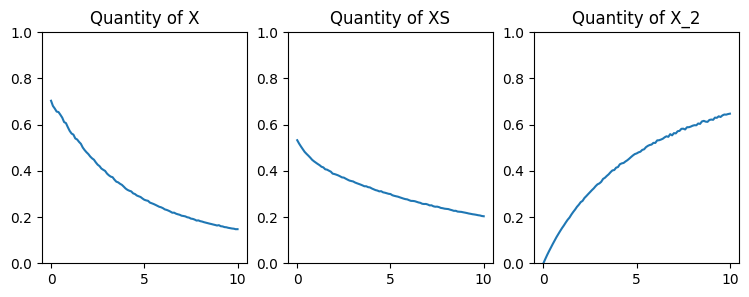

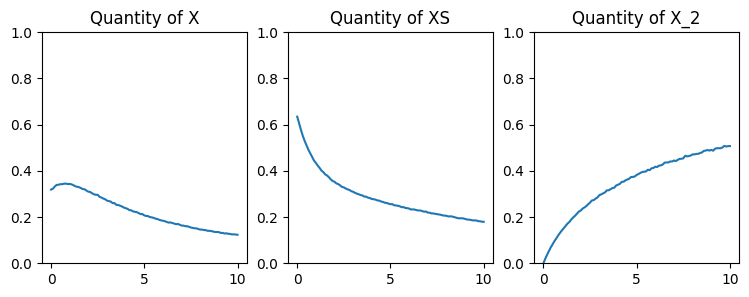

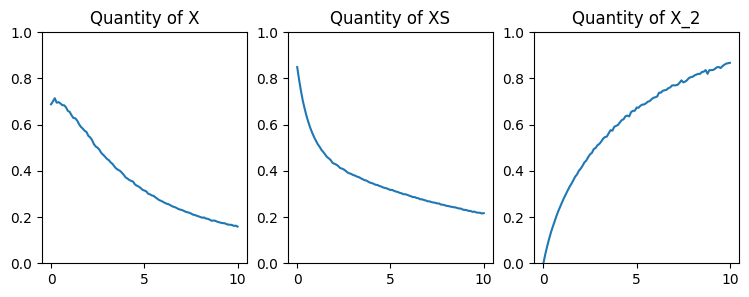

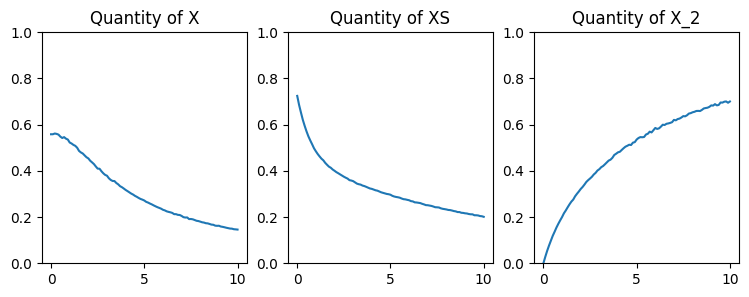

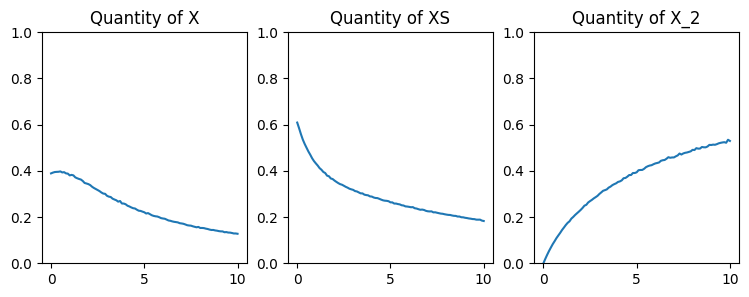

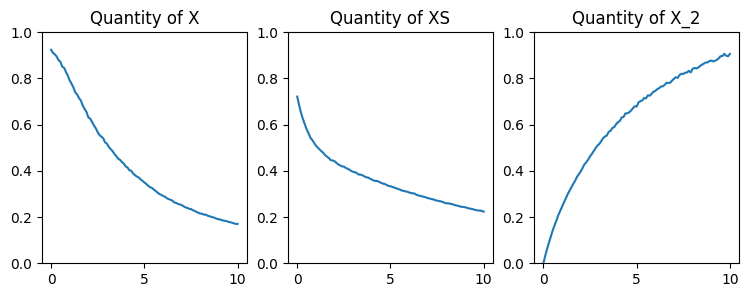

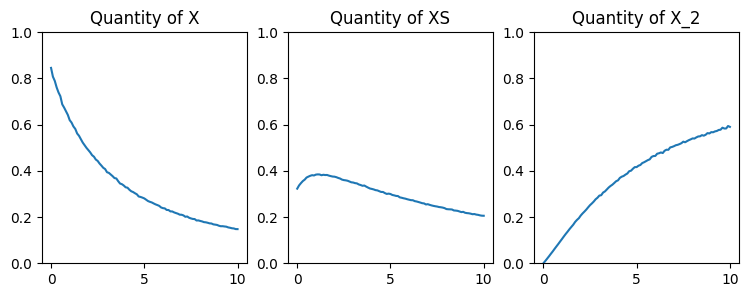

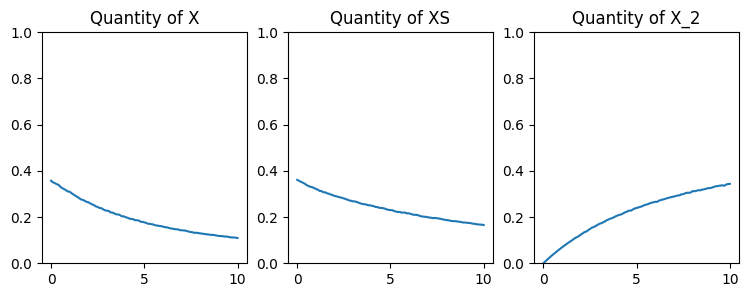

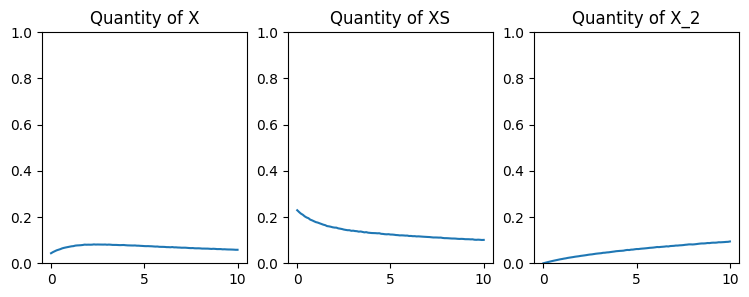

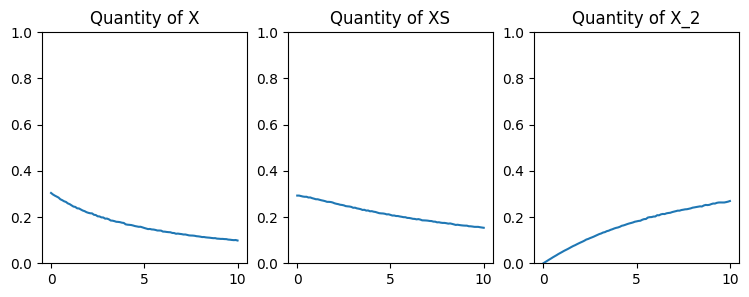

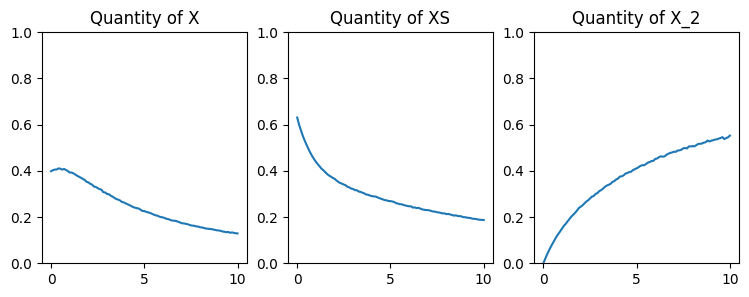

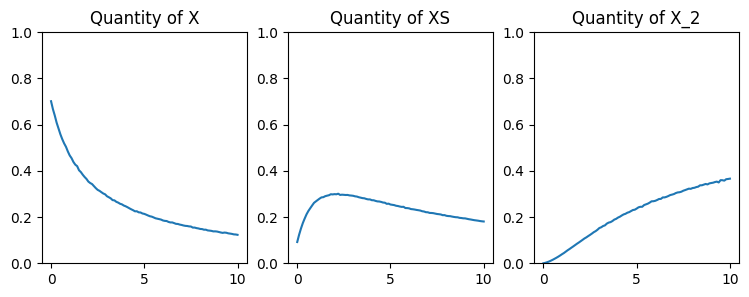

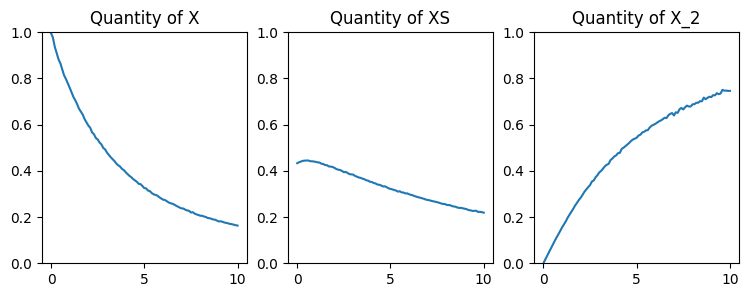

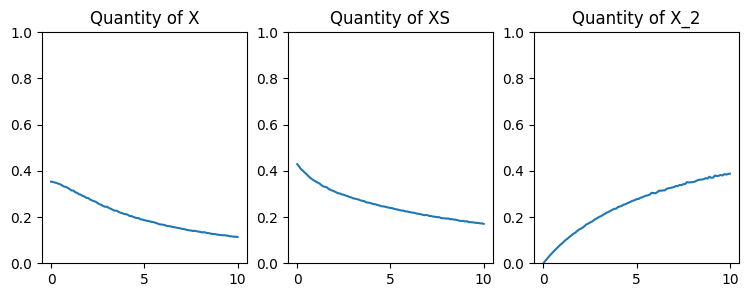

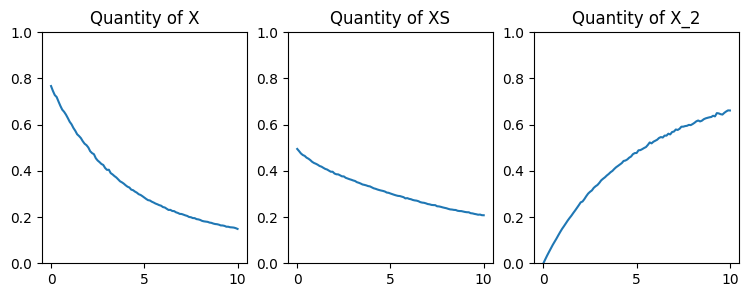

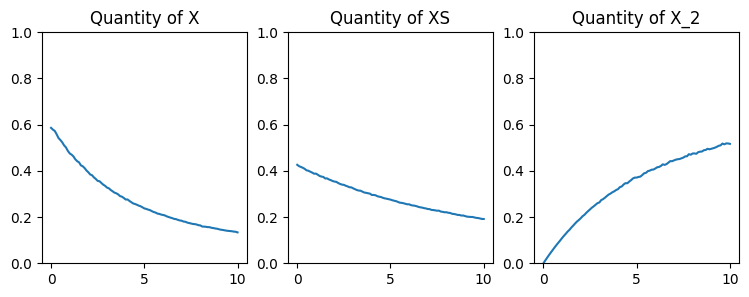

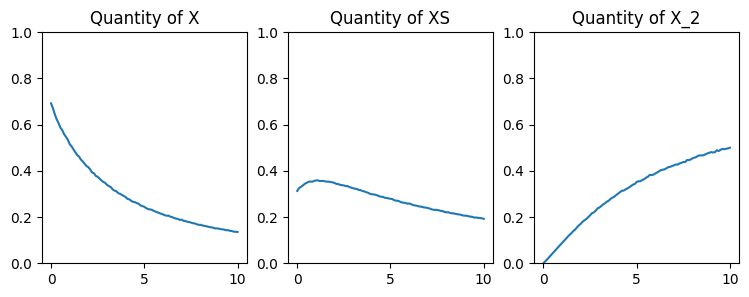

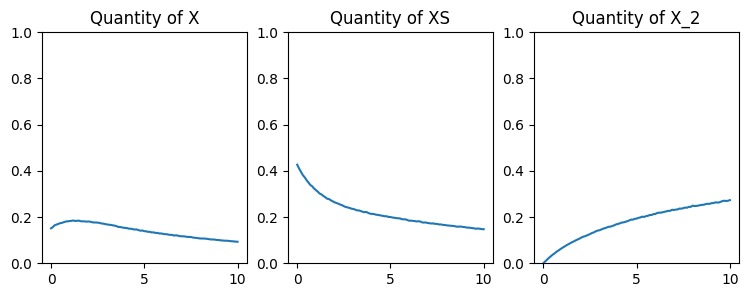

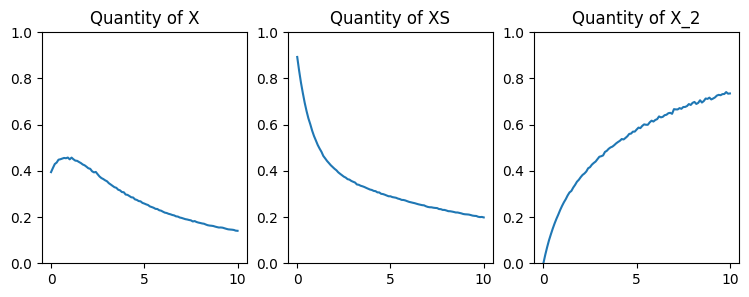

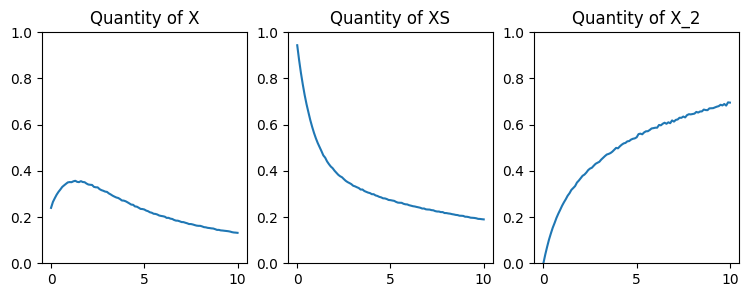

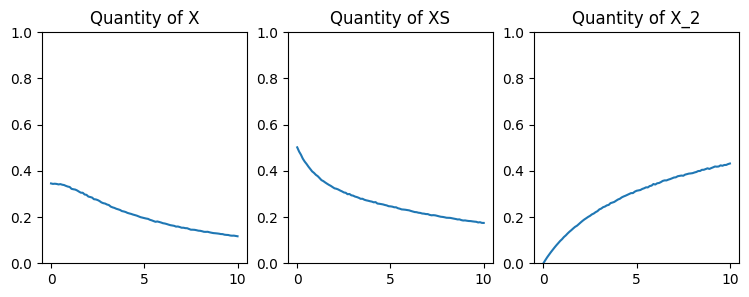

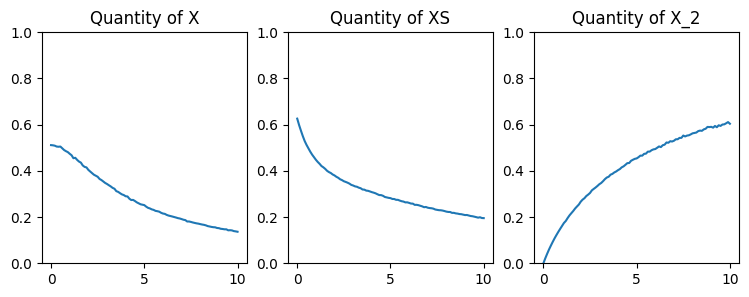

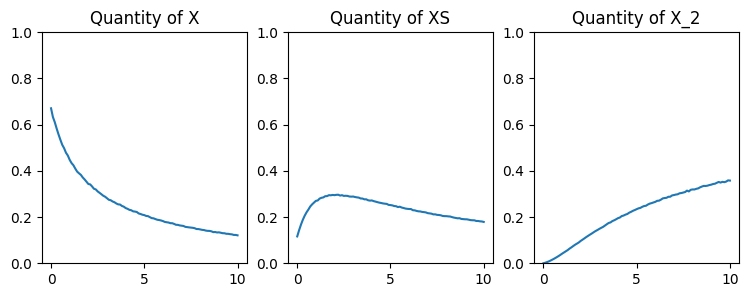

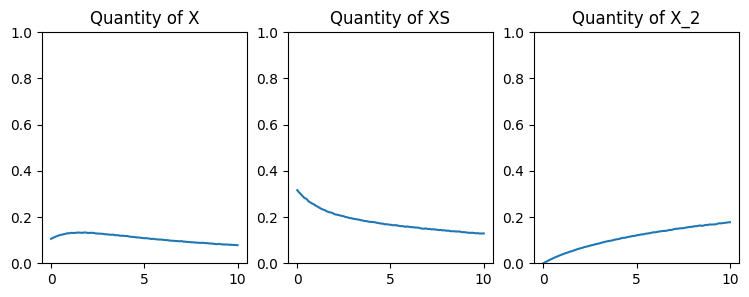

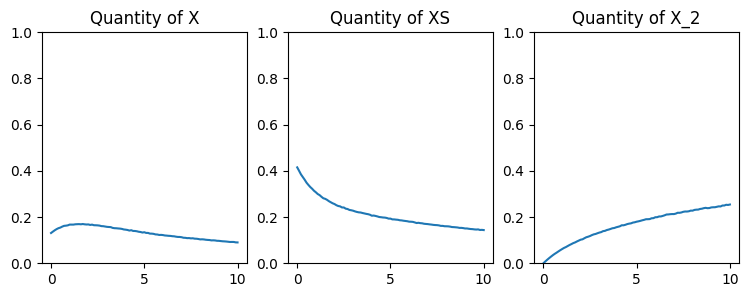

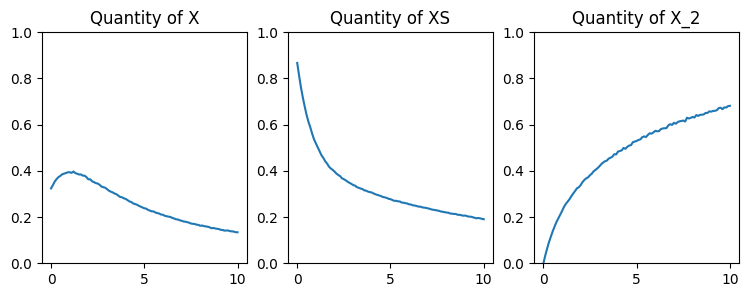

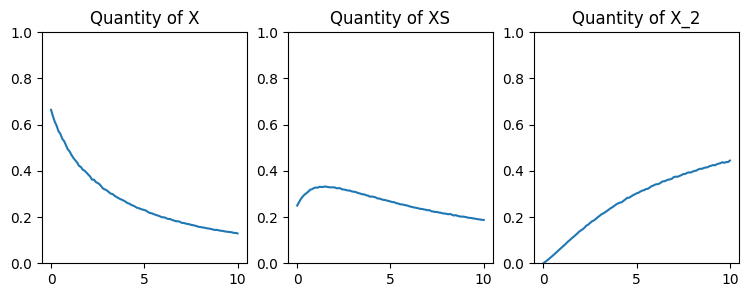

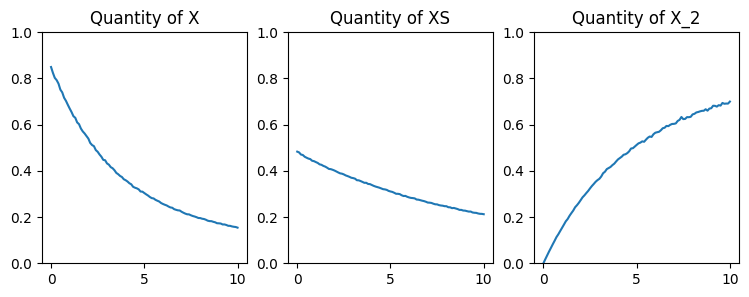

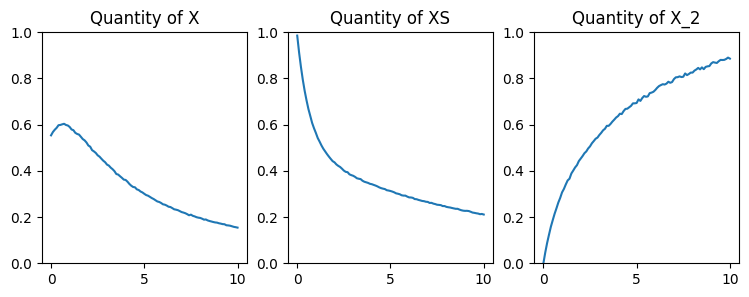

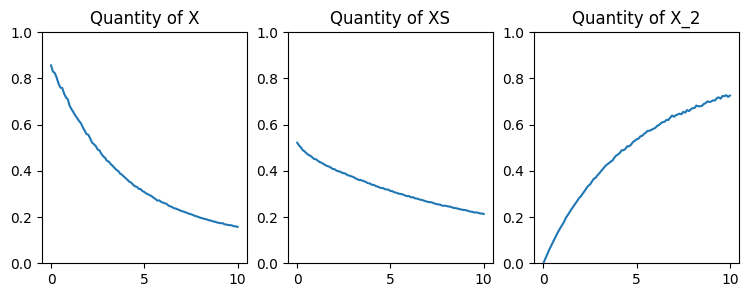

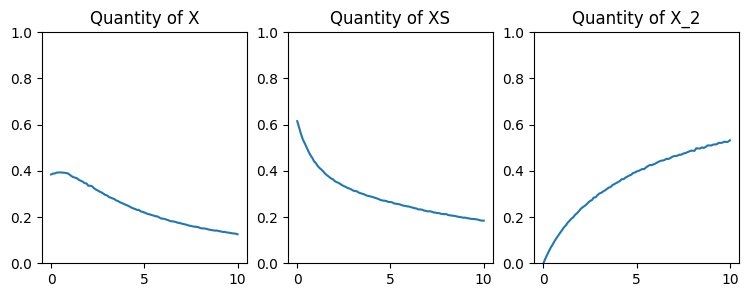

In [3]:
# plotting C_xs for data identification 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


for i in range(n_exp):
    
    fig, axs = plt.subplots(1,3,figsize=(9,3))
    axs[0].set_ylim(0,1)
    axs[1].set_ylim(0,1)
    axs[2].set_ylim(0,1)
    axs[0].plot(train_t,train_x[i])
    axs[0].set_title('Quantity of X')
    axs[1].plot(train_t,train_xs[i])
    axs[1].set_title('Quantity of XS')
    axs[2].plot(train_t,train_x_2[i])
    axs[2].set_title('Quantity of X_2')
    plt.show()
    break



<h3> Building models



In [4]:
from torch import nn

class FirstModel(nn.Module):
    def __init__(self) -> None:
        super(FirstModel,self).__init__()
        self.linear1 = nn.Linear(3,15)
        self.linear2 = nn.Linear(15,15)
        self.linear3 = nn.Linear(15,3)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        return x 


c:\Users\tuank\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h3> Creating dataloaders


In [5]:
import torch

In [6]:
data_in , data_out = [] , []

for i in range(n_exp):
    for j in range(n_t-1):
        data_in.append([train_x[i][j],train_xs[i][j],train_x_2[i][j]])
        data_out.append([train_x[i][j+1],train_xs[i][j+1],train_x_2[i][j+1]])

from sklearn.model_selection import train_test_split



data_in = torch.FloatTensor(data_in)
data_out = torch.FloatTensor(data_out)

print(data_in[0])
print(data_out[0])

train_in , val_in , train_out , val_out = train_test_split(data_in,data_out,test_size=0.3,random_state=42)

print(len(train_in))
print(len(val_in))


tensor([0.6674, 0.6964, 0.0000])
tensor([0.6671, 0.6615, 0.0275])
3500
1500


In [7]:
class Data(torch.utils.data.Dataset):
    def __init__(self,inp,out) -> None:
        self.x = inp 
        self.y = out

    def __len__(self):
        return len(self.x)

    def __getitem__(self,idx):
        return self.x[idx] , self.y[idx]

In [8]:
train , val = Data(train_in,train_out) , Data(val_in,val_out)

train_dataloader = torch.utils.data.DataLoader(train,batch_size=32)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=32)

<h3> Train models

In [9]:


model = FirstModel()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

model = model.to(device)
criterion = criterion.to(device)

In [10]:
from tqdm import tqdm
min_val_loss=100000000000
for epoch in range(20):
  total_loss_train=0
  total_acc_train=0
  for x, y in tqdm(train_dataloader):
    x = x.to(device)
    y = y.to(device)

    output = model(x.float())

    batch_loss = criterion(output, y)
    total_loss_train += batch_loss.item()

    acc = (output-y).pow(2).sum(1).sqrt().sum().item()

    total_acc_train += acc

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
  
  total_loss_val=0
  total_acc_val=0

  with torch.no_grad():
    for x, y in tqdm(val_dataloader):

      x = x.to(device)
      y = y.to(device)

      output = model(x.float())

      batch_loss = criterion(output, y)
      total_loss_val += batch_loss.item()

      acc = (output-y).pow(2).sum(1).sqrt().sum().item()
      total_acc_val += acc
  
  print(
      f'Epochs: {epoch+1} | Train Loss: {total_loss_train / len(train):.3f}\
      | Train Diff: {total_acc_train/len(train):.3f}\
      | Val Loss: {total_loss_val/len(val):.3f}\
      | Val Diff:{total_acc_val/len(val):.3f}'
  )

  if min_val_loss>total_loss_val/len(val):
    min_val_loss = total_loss_val/len(val)
    torch.save(model.state_dict(), "simplemodel.pt")
    print(f"Save model because val loss improve loss {min_val_loss:.3f}")


100%|██████████| 47/47 [00:00<00:00, 866.68it/s]


Epochs: 1 | Train Loss: 0.002      | Train Diff: 0.413      | Val Loss: 0.002      | Val Diff:0.396
Save model because val loss improve loss 0.002


100%|██████████| 47/47 [00:00<00:00, 857.41it/s]


Epochs: 2 | Train Loss: 0.001      | Train Diff: 0.286      | Val Loss: 0.001      | Val Diff:0.185
Save model because val loss improve loss 0.001


100%|██████████| 47/47 [00:00<00:00, 842.42it/s]


Epochs: 3 | Train Loss: 0.000      | Train Diff: 0.097      | Val Loss: 0.000      | Val Diff:0.027
Save model because val loss improve loss 0.000


100%|██████████| 47/47 [00:00<00:00, 1571.81it/s]


Epochs: 4 | Train Loss: 0.000      | Train Diff: 0.024      | Val Loss: 0.000      | Val Diff:0.019
Save model because val loss improve loss 0.000


100%|██████████| 47/47 [00:00<00:00, 1571.18it/s]


Epochs: 5 | Train Loss: 0.000      | Train Diff: 0.019      | Val Loss: 0.000      | Val Diff:0.016
Save model because val loss improve loss 0.000


100%|██████████| 47/47 [00:00<00:00, 1517.96it/s]


Epochs: 6 | Train Loss: 0.000      | Train Diff: 0.014      | Val Loss: 0.000      | Val Diff:0.010
Save model because val loss improve loss 0.000


100%|██████████| 47/47 [00:00<00:00, 1274.52it/s]


Epochs: 7 | Train Loss: 0.000      | Train Diff: 0.009      | Val Loss: 0.000      | Val Diff:0.006
Save model because val loss improve loss 0.000


100%|██████████| 47/47 [00:00<00:00, 849.42it/s]


Epochs: 8 | Train Loss: 0.000      | Train Diff: 0.006      | Val Loss: 0.000      | Val Diff:0.005
Save model because val loss improve loss 0.000


100%|██████████| 47/47 [00:00<00:00, 799.51it/s]


Epochs: 9 | Train Loss: 0.000      | Train Diff: 0.005      | Val Loss: 0.000      | Val Diff:0.005
Save model because val loss improve loss 0.000


100%|██████████| 47/47 [00:00<00:00, 1243.10it/s]


Epochs: 10 | Train Loss: 0.000      | Train Diff: 0.004      | Val Loss: 0.000      | Val Diff:0.004
Save model because val loss improve loss 0.000


100%|██████████| 47/47 [00:00<00:00, 1347.43it/s]


Epochs: 11 | Train Loss: 0.000      | Train Diff: 0.004      | Val Loss: 0.000      | Val Diff:0.004
Save model because val loss improve loss 0.000


100%|██████████| 47/47 [00:00<00:00, 848.26it/s]


Epochs: 12 | Train Loss: 0.000      | Train Diff: 0.004      | Val Loss: 0.000      | Val Diff:0.004
Save model because val loss improve loss 0.000


100%|██████████| 47/47 [00:00<00:00, 1387.23it/s]


Epochs: 13 | Train Loss: 0.000      | Train Diff: 0.004      | Val Loss: 0.000      | Val Diff:0.004
Save model because val loss improve loss 0.000


100%|██████████| 47/47 [00:00<00:00, 1158.70it/s]


Epochs: 14 | Train Loss: 0.000      | Train Diff: 0.004      | Val Loss: 0.000      | Val Diff:0.004
Save model because val loss improve loss 0.000


100%|██████████| 47/47 [00:00<00:00, 1307.79it/s]


Epochs: 15 | Train Loss: 0.000      | Train Diff: 0.004      | Val Loss: 0.000      | Val Diff:0.004
Save model because val loss improve loss 0.000


100%|██████████| 47/47 [00:00<00:00, 1208.93it/s]


Epochs: 16 | Train Loss: 0.000      | Train Diff: 0.004      | Val Loss: 0.000      | Val Diff:0.004
Save model because val loss improve loss 0.000


100%|██████████| 47/47 [00:00<00:00, 1310.82it/s]


Epochs: 17 | Train Loss: 0.000      | Train Diff: 0.005      | Val Loss: 0.000      | Val Diff:0.004


100%|██████████| 47/47 [00:00<00:00, 1387.72it/s]


Epochs: 18 | Train Loss: 0.000      | Train Diff: 0.005      | Val Loss: 0.000      | Val Diff:0.004


100%|██████████| 47/47 [00:00<00:00, 1309.83it/s]


Epochs: 19 | Train Loss: 0.000      | Train Diff: 0.005      | Val Loss: 0.000      | Val Diff:0.004


100%|██████████| 47/47 [00:00<00:00, 1281.97it/s]

Epochs: 20 | Train Loss: 0.000      | Train Diff: 0.005      | Val Loss: 0.000      | Val Diff:0.004


<h3> Output prediction


In [11]:
model = FirstModel()
model = model.to(device)
model.load_state_dict(torch.load("simplemodel.pt"))

<All keys matched successfully>

In [34]:
test_file = open('test.txt')
test_data = json.load(test_file)
print(test_data)

{'description': 'This dictionary contains 4 keys {t, c_{XS}, c_{X}, c_{X_2}}. t contains a list of n_t measurement times. For the rest of the three keys, each contains an array of size [n_exp, n_t]. The first dimension is the index of the simulation run, and the second dimension is the index of the time step. That is, c[i,j] is the concentration/coverage at the j-th time step (time=t[j]), for the i-th simulation run.', 't': [0.0], 'c_{XS}': [[0.12089370929034385], [0.8253860150840294], [0.6040286359651886], [0.5455257871432416], [0.3453918617024181], [0.30397387376139884], [0.4168950986589867], [0.6818980330177542], [0.8754072374252352], [0.5087953273213867]], 'c_{X}': [[0.31598310321900014], [0.3564868160801711], [0.1689159368836473], [0.830395094748971], [0.33726382476053196], [0.55527120562469], [0.5778524129591731], [0.5237932240603652], [0.002698848671190545], [0.9816777234188966]], 'c_{X_2}': [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]}


In [35]:
test_x = test_data['c_{X}']
test_xs = test_data['c_{XS}']
test_x_2 = test_data['c_{X_2}']
n_exp_test = len(test_x)
print(n_exp_test)


10


In [36]:
for i in range(n_exp_test):
    for j in range(100):
            y = torch.tensor([test_x[i][-1],test_xs[i][-1],test_x_2[i][-1]]).to(device)
            output = model(y)
            test_x[i].append(output[0].item()) 
            test_xs[i].append(output[1].item())
            test_x_2[i].append(output[2].item())
           


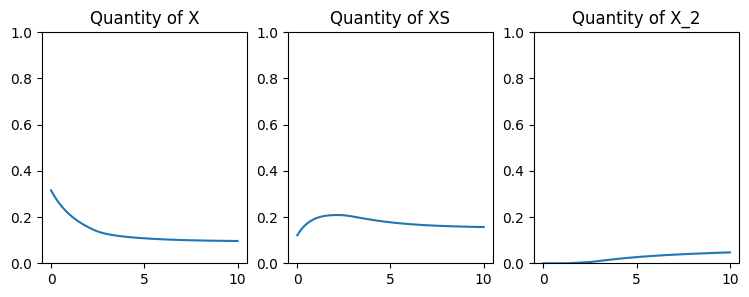

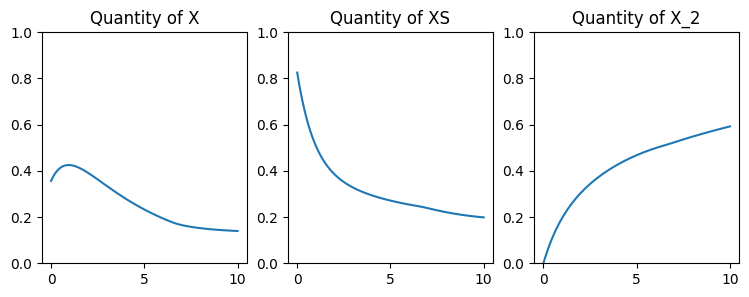

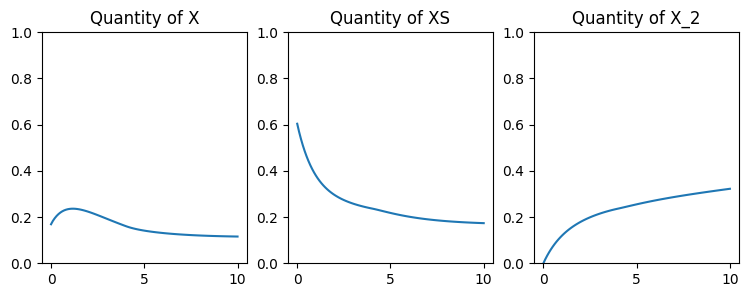

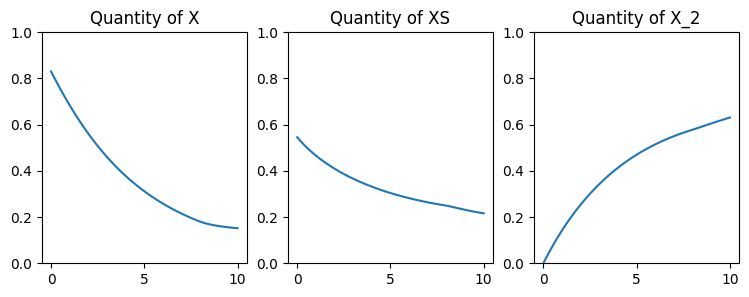

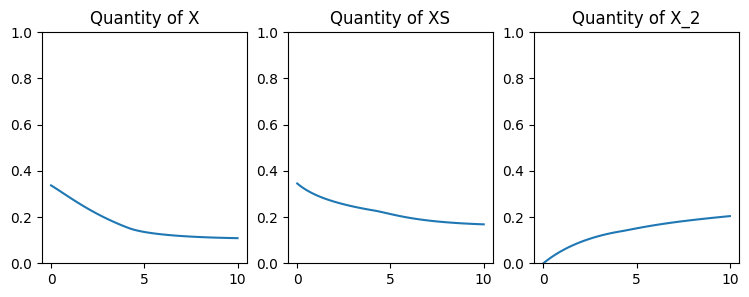

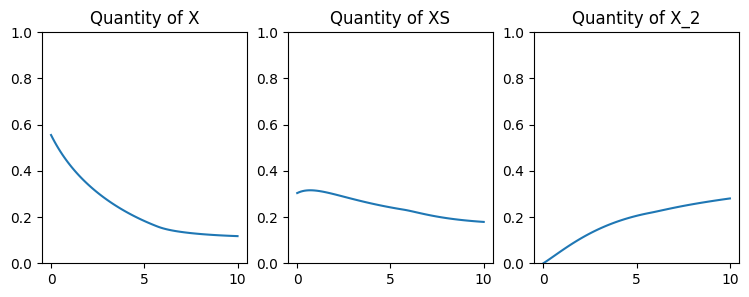

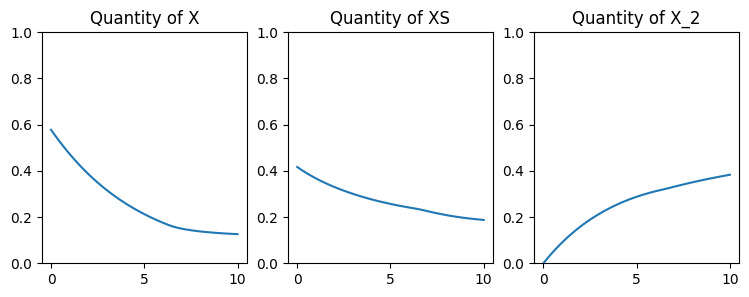

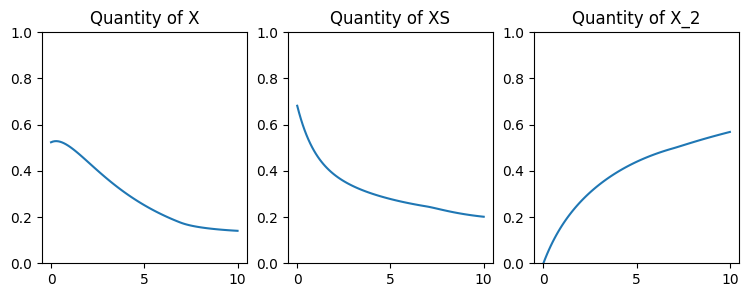

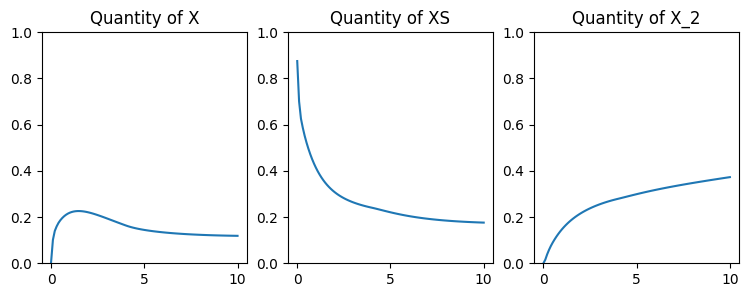

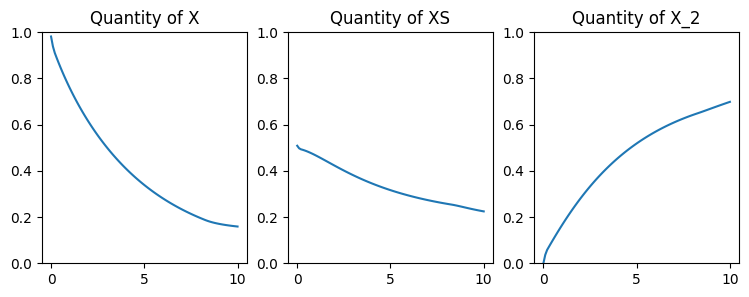

In [37]:
for i in range(n_exp_test):

    fig, axs = plt.subplots(1,3,figsize=(9,3))
    axs[0].set_ylim(0,1)
    axs[1].set_ylim(0,1)
    axs[2].set_ylim(0,1)
    axs[0].plot(train_t,test_x[i])
    axs[0].set_title('Quantity of X')
    axs[1].plot(train_t,test_xs[i])
    axs[1].set_title('Quantity of XS')
    axs[2].plot(train_t,test_x_2[i])
    axs[2].set_title('Quantity of X_2')
    plt.show()